In [1]:
import rasterio as rs
import numpy as np
from rasterio.plot import show
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
# reprojecting GTI crs to amersfoort so that units are meters instead of degrees 
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:28992'

with rs.open('data/nl_solarAtlas/GTI.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rs.open('data/nl_solarAtlas/GTI_amersfoort.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rs.band(src, i),
                destination=rs.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [4]:
r = rs.open('data/nl_solarAtlas/GTI.tif')
r.crs

CRS.from_epsg(4326)

In [5]:
# get rid of strange values from re-projection
gti_raster = rs.open('data/nl_solarAtlas/GTI_amersfoort.tif') 
gti = gti_raster.read(1)
gti = np.where(gti < 1, np.nan, gti) # get rid of strange values from re-projection 
gti_raster.close()

# re-write and close raster 
gti_raster = rs.open(
    'data/nl_solarAtlas/GTI_amersfoort.tif', 'w', driver='GTiff',
    height=gti.shape[0], width=gti.shape[1], 
    count=1, dtype=gti.dtype,
    crs='EPSG:28992', transform=gti_raster.transform
)
gti_raster.write(gti, 1)
gti_raster.close()

In [6]:
# raster stats
gti_raster = rs.open('data/nl_solarAtlas/GTI_amersfoort.tif') 
gti = gti_raster.read(1)
affine = gti_raster.transform
pixelArea = round(affine[0]) * round(-affine[4])
print(
    'each pixel in the raster is {}m by {}m, or {} m2, or {} km2'
    .format(round(affine[0]), round(-affine[4]), pixelArea, round(pixelArea/1000000,2))
)
print('there are ~{} million pixels in the raster'.format(round(gti.shape[0] * gti.shape[1] / 1000000, 1)))

each pixel in the raster is 219m by 219m, or 47961 m2, or 0.05 km2
there are ~3.3 million pixels in the raster


In [7]:
from rasterio.enums import Resampling

upscale_factor = 1/10

with rs.open("data/nl_solarAtlas/GTI_amersfoort.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.average
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [8]:
gtiAgg_raster = rs.open('data/nl_solarAtlas/GTI_amersfoort_agg.tif')
gtiAgg = gtiAgg_raster.read(1)

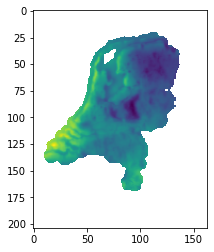

<AxesSubplot:>

In [9]:
show(gtiAgg)

In [13]:
gtiAgg.shape[0] * gtiAgg.shape[1]
gtiAgg_raster.close()

In [14]:
# re-write and close raster 
new_raster = rs.open(
    'data/nl_solarAtlas/GTI_amersfoort_agg.tif', 'w', driver='GTiff',
    height=gtiAgg.shape[0], width=gtiAgg.shape[1], 
    count=1, dtype=gtiAgg.dtype,
    crs='EPSG:28992', transform=transform
)
new_raster.write(gtiAgg, 1)
new_raster.close()

In [15]:
from rasterio.features import shapes
mask = None
with rs.Env():
    with rs.open('data/nl_solarAtlas/GTI_amersfoort_agg.tif') as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform)))
geoms = list(results)

In [16]:
# make shpfile 
gdf = gpd.GeoDataFrame.from_features(geoms)
gdf = gdf.set_crs('EPSG:28992')
gdf.rename(columns={'raster_val': 'gti'}, inplace=True)

# calculate energy produced 
pixelSize = gdf.loc[0, 'geometry'].area
gdf['kwhPerYear'] = gdf.gti * pixelSize * 0.15

# remove nan rows
gdf = gdf[~gdf.gti.isna()]
gdf.head()

geometry          gti  \
0  POLYGON ((223535.394 627489.748, 223535.394 62...  1233.512573   
1  POLYGON ((225734.589 627489.748, 225734.589 62...  1232.942139   
2  POLYGON ((227933.783 627489.748, 227933.783 62...  1232.887817   
3  POLYGON ((230132.978 627489.748, 230132.978 62...  1232.902832   
4  POLYGON ((232332.172 627489.748, 232332.172 62...  1232.727783   

     kwhPerYear  
0  8.939966e+08  
1  8.935832e+08  
2  8.935438e+08  
3  8.935547e+08  
4  8.934278e+08

<AxesSubplot:>

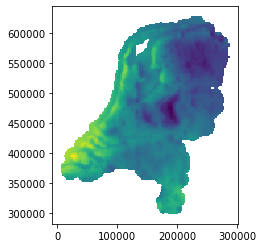

In [17]:
gdf.plot(column='kwhPerYear')

In [18]:
pc2 = gpd.read_file('data/nl_pc2_amersfoort.shp')
pc4 = gpd.read_file('data/nl_pc4_amersfoort.shp')

In [19]:
pc2_buffer = pc2.copy()
pc2_buffer.geometry = pc2_buffer.geometry.buffer(10)
pc2_buffer.head()

pc                                           geometry
0  10  MULTIPOLYGON (((110450.771 491739.312, 110453....
1  11  MULTIPOLYGON (((126557.357 495778.377, 126557....
2  12  POLYGON ((129993.730 468287.027, 129993.854 46...
3  13  MULTIPOLYGON (((136880.669 488569.259, 136880....
4  14  MULTIPOLYGON (((135116.398 479564.320, 135115....

In [36]:
%%time
nl = pc2_buffer.geometry.unary_union
nl = gpd.GeoDataFrame(nl)
nl.rename(columns={0: 'geometry'}, inplace=True)
nl = nl.set_crs('EPSG:28992')

CPU times: total: 22 s
Wall time: 22 s


In [52]:
%%time
res_intersection = gpd.overlay(gdf, nl, how='intersection')

CPU times: total: 13min 33s
Wall time: 13min 37s


In [27]:
%%time
res_intersection = gpd.overlay(gdf, pc2, how='intersection')

CPU times: total: 27.2 s
Wall time: 27.4 s


<AxesSubplot:>

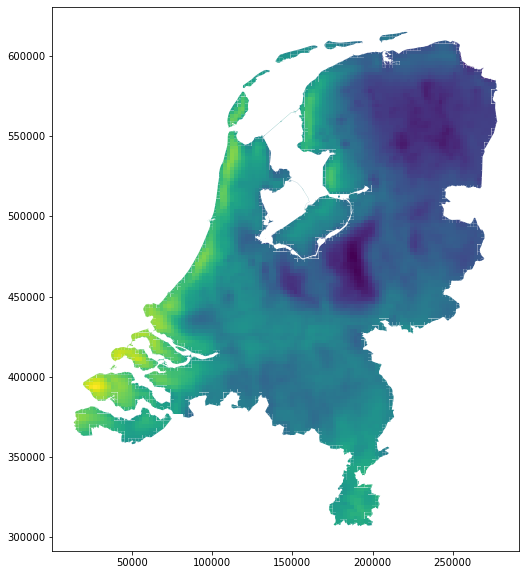

In [53]:
res_intersection.plot(column='kwhPerYear', figsize=(10,10))

In [54]:
gdf.to_file('data/nl_solarAtlas/solarPotential.shp')
res_intersection.to_file('data/nl_solarAtlas/solarPotential_cropped.shp')

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
